### 0. Import Modules

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import distributions
import py_vollib.black_scholes as black_scholes
import py_vollib_vectorized
from statistics import median

### 1. Realized Volatility

In [2]:
returns = distributions.get_returns("SPY", "2022-01-01", "2022-12-31")
spx_data = pd.DataFrame({"Log Returns":returns})
spx_data

[*********************100%%**********************]  1 of 1 completed


,Log Returns
Date,
2022-01-03,NaN
2022-01-04,-0.000335
2022-01-05,-0.019389
2022-01-06,-0.000940
2022-01-07,-0.003961
...,...
2022-12-23,0.005736
2022-12-27,-0.003951
2022-12-28,-0.012506


In [3]:
def get_realized_volatility(returns, period=1):
    """
    Returns the volatility of the given series within the given instantaneous time periods
    :param returns: Series of the returns of a security
    :param period: Time period to calculate volatility over
    """
    return returns.rolling(window=period).std(ddof=0)*np.sqrt(252)

In [4]:
"""
Finding realized volatility for SPX over 21 trading days (approximately one month)
"""
spx_data["Realized Volatility"] = get_realized_volatility(spx_data["Log Returns"], 21)

In [5]:
spx_data.tail()

,Log Returns,Realized Volatility
Date,,
2022-12-23,0.005736,0.201405
2022-12-27,-0.003951,0.201371
2022-12-28,-0.012506,0.198783
2022-12-29,0.017840,0.209980
2022-12-30,-0.002638,0.176059


<Axes: xlabel='Date'>

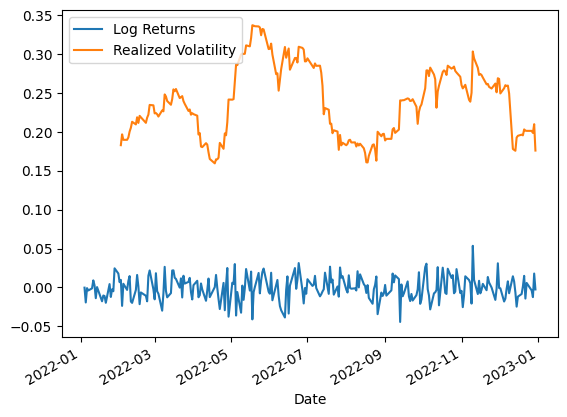

In [6]:
spx_data.plot()

### 2. Options Implied Volatility

In [10]:
"""
Get option data
"""
options = pd.DataFrame()
for quarter in range(1, 5):
    for part in range(1, 4):
        df = pd.read_csv(f"options_chain_data/spy_eod_2022/spy_eod_2022{'%02d' % (part + (3*(quarter-1)))}.txt")
        df = df.set_index(df.columns[1])
        df = df.rename(
            columns = lambda x: x.replace(" ", "").replace("[", "").replace("]", "").replace("_"," ")
            )
        df = df.drop(columns = df.columns[[0,5]])
        options = pd.concat((options,df))

C:\Users\Tayo\AppData\Local\Temp\ipykernel_30396\543330079.py:7: DtypeWarning: Columns (15,17,18,20,21,23,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"options_chain_data/spy_eod_2022/spy_eod_2022{'%02d' % (part + (3*(quarter-1)))}.txt")
C:\Users\Tayo\AppData\Local\Temp\ipykernel_30396\543330079.py:7: DtypeWarning: Columns (15,17,18,20,21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"options_chain_data/spy_eod_2022/spy_eod_2022{'%02d' % (part + (3*(quarter-1)))}.txt")
C:\Users\Tayo\AppData\Local\Temp\ipykernel_30396\543330079.py:7: DtypeWarning: Columns (15,17,18,20,21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"options_chain_data/spy_eod_2022/spy_eod_2022{'%02d' % (part + (3*(quarter-1)))}.txt")
C:\Users\Tayo\AppData\Local\Temp\ipykernel_30396\543330079.py:7: DtypeWarning: Columns (8,9,10,11,12,15,17,18,20,21,23,24,25,26,27,28

In [11]:
options = options.replace(" ", np.nan)

In [12]:
for col in ["C IV", "P IV", "C DELTA"]:
    options[col] = pd.to_numeric(options[col])
options

,QUOTE DATE,QUOTE TIME HOURS,UNDERLYING LAST,EXPIRE DATE,DTE,C DELTA,C GAMMA,C VEGA,C THETA,C RHO,...,P LAST,P DELTA,P GAMMA,P VEGA,P THETA,P RHO,P IV,P VOLUME,STRIKE DISTANCE,STRIKE DISTANCE PCT
[QUOTE_READTIME],,,,,,,,,,,,,,,,,,,,,
2022-01-03 16:00,2022-01-03,16.0,477.77,2022-01-03,0.0,1.00000,0.0,0.0,0.0,0.0,...,0.01,-0.0003,-0.00003,0.00049,-0.00488,0.0,4.60994,0.000000,242.8,0.508
2022-01-03 16:00,2022-01-03,16.0,477.77,2022-01-03,0.0,1.00000,0.0,0.0,0.0,0.0,...,0.01,-0.00042,0.00004,0.00011,-0.0051,0.0,4.47957,0.000000,237.8,0.498
2022-01-03 16:00,2022-01-03,16.0,477.77,2022-01-03,0.0,1.00000,0.0,0.0,0.0,0.0,...,0.01,-0.00036,0.0,0.00028,-0.00498,0.0,4.35078,0.000000,232.8,0.487
2022-01-03 16:00,2022-01-03,16.0,477.77,2022-01-03,0.0,1.00000,0.0,0.0,0.0,0.0,...,0.01,-0.00069,0.00006,0.0,-0.0052,0.0,4.22464,0.000000,227.8,0.477
2022-01-03 16:00,2022-01-03,16.0,477.77,2022-01-03,0.0,1.00000,0.0,0.0,0.0,0.0,...,0.01,-0.00004,0.00003,0.00045,-0.00526,0.0,4.10185,0.000000,222.8,0.466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-30 16:00,2022-12-30,16.0,382.44,2025-12-19,1085.0,0.10595,0.0015,1.19348,-0.01204,1.05129,...,0.0,-1.0,0.0,0.0,0.0,0.0,NaN,NaN,247.6,0.647
2022-12-30 16:00,2022-12-30,16.0,382.44,2025-12-19,1085.0,0.09392,0.0014,1.09723,-0.01082,0.94207,...,0.0,-0.89431,0.00307,0.72687,-0.00434,-0.2033,0.29557,NaN,252.6,0.660
2022-12-30 16:00,2022-12-30,16.0,382.44,2025-12-19,1085.0,0.09279,0.00137,1.08956,-0.01114,0.93199,...,0.0,-0.88536,0.00298,0.78662,-0.00524,-1.78777,0.30289,NaN,257.6,0.673


In [13]:
verbose_options = options
options = verbose_options.drop(columns = verbose_options.columns[[6,7,8,9,21,22,23,24,25]])
options

,QUOTE DATE,QUOTE TIME HOURS,UNDERLYING LAST,EXPIRE DATE,DTE,C DELTA,C IV,C VOLUME,C LAST,C SIZE,...,C ASK,STRIKE,P BID,P ASK,P SIZE,P LAST,P IV,P VOLUME,STRIKE DISTANCE,STRIKE DISTANCE PCT
[QUOTE_READTIME],,,,,,,,,,,,,,,,,,,,,
2022-01-03 16:00,2022-01-03,16.0,477.77,2022-01-03,0.0,1.00000,NaN,NaN,0.0,2 x 1,...,243.3,235.0,0.0,0.01,0 x 2471,0.01,4.60994,0.000000,242.8,0.508
2022-01-03 16:00,2022-01-03,16.0,477.77,2022-01-03,0.0,1.00000,NaN,NaN,0.0,1 x 1,...,238.3,240.0,0.0,0.01,0 x 2337,0.01,4.47957,0.000000,237.8,0.498
2022-01-03 16:00,2022-01-03,16.0,477.77,2022-01-03,0.0,1.00000,NaN,NaN,0.0,1 x 1,...,233.3,245.0,0.0,0.01,0 x 2327,0.01,4.35078,0.000000,232.8,0.487
2022-01-03 16:00,2022-01-03,16.0,477.77,2022-01-03,0.0,1.00000,NaN,NaN,0.0,1 x 1,...,228.3,250.0,0.0,0.01,0 x 2327,0.01,4.22464,0.000000,227.8,0.477
2022-01-03 16:00,2022-01-03,16.0,477.77,2022-01-03,0.0,1.00000,NaN,NaN,0.0,1 x 1,...,223.3,255.0,0.0,0.01,0 x 2327,0.01,4.10185,0.000000,222.8,0.466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-30 16:00,2022-12-30,16.0,382.44,2025-12-19,1085.0,0.10595,0.17770,2.000000,5.71,1 x 2,...,10.0,630.0,243.0,250.5,10 x 1,0.0,NaN,NaN,247.6,0.647
2022-12-30 16:00,2022-12-30,16.0,382.44,2025-12-19,1085.0,0.09392,0.17304,NaN,0.0,2 x 2,...,7.0,635.0,247.66,257.5,1 x 1,0.0,0.29557,NaN,252.6,0.660
2022-12-30 16:00,2022-12-30,16.0,382.44,2025-12-19,1085.0,0.09279,0.17558,NaN,0.0,2 x 2,...,7.0,640.0,253.0,262.5,1 x 1,0.0,0.30289,NaN,257.6,0.673


In [14]:
options[(options["DTE"] == 21)].head(20)

,QUOTE DATE,QUOTE TIME HOURS,UNDERLYING LAST,EXPIRE DATE,DTE,C DELTA,C IV,C VOLUME,C LAST,C SIZE,...,C ASK,STRIKE,P BID,P ASK,P SIZE,P LAST,P IV,P VOLUME,STRIKE DISTANCE,STRIKE DISTANCE PCT
[QUOTE_READTIME],,,,,,,,,,,,,,,,,,,,,
2022-01-03 16:00,2022-01-03,16.0,477.77,2022-01-24,21.0,0.99544,0.38851,NaN,0.0,48 x 73,...,103.2,375.0,0.09,0.11,3710 x 4960,0.18,0.40675,0.000000,102.8,0.215
2022-01-03 16:00,2022-01-03,16.0,477.77,2022-01-24,21.0,0.99491,0.36874,NaN,0.0,48 x 58,...,98.19,380.0,0.11,0.12,2381 x 4371,0.16,0.39340,4.000000,97.8,0.205
2022-01-03 16:00,2022-01-03,16.0,477.77,2022-01-24,21.0,0.98845,0.39880,NaN,0.0,48 x 48,...,93.32,385.0,0.12,0.13,2244 x 295,0.22,0.37669,0.000000,92.8,0.194
2022-01-03 16:00,2022-01-03,16.0,477.77,2022-01-24,21.0,0.98900,0.37041,NaN,0.0,73 x 58,...,88.34,390.0,0.14,0.15,1746 x 533,0.2,0.36437,5.000000,87.8,0.184
2022-01-03 16:00,2022-01-03,16.0,477.77,2022-01-24,21.0,0.99008,0.34199,NaN,0.0,73 x 48,...,83.27,395.0,0.16,0.17,1432 x 1088,0.25,0.34990,1.000000,82.8,0.173
2022-01-03 16:00,2022-01-03,16.0,477.77,2022-01-24,21.0,0.98071,0.35939,NaN,0.0,5 x 83,...,78.41,400.0,0.18,0.19,1311 x 533,0.21,0.33498,3.000000,77.8,0.163
2022-01-03 16:00,2022-01-03,16.0,477.77,2022-01-24,21.0,0.97889,0.34158,NaN,0.0,5 x 85,...,73.42,405.0,0.21,0.22,133 x 1637,0.23,0.32096,20.000000,72.8,0.152
2022-01-03 16:00,2022-01-03,16.0,477.77,2022-01-24,21.0,0.97623,0.32200,NaN,0.0,5 x 48,...,68.43,410.0,0.23,0.25,2112 x 2096,0.38,0.30550,0.000000,67.8,0.142
2022-01-03 16:00,2022-01-03,16.0,477.77,2022-01-24,21.0,0.98047,0.28413,NaN,0.0,15 x 78,...,63.37,415.0,0.26,0.28,1453 x 1538,0.42,0.28912,0.000000,62.8,0.131


In [15]:
spx_iv_itm = options[(options["DTE"] == 21) & options["C DELTA"] > 0.6].groupby("EXPIRE DATE").agg(
    {"C IV":[lambda x: max(x.dropna()), lambda x: min(x.dropna()), lambda x: median(x.dropna())], 
     "P IV": [lambda x: max(x.dropna()), lambda x: min(x.dropna()), lambda x: median(x.dropna())]}
    )
spx_iv_atm = options[(options["DTE"] == 21) & (0.4 <= options["C DELTA"]) & (options["C DELTA"] <= 0.6)].groupby("EXPIRE DATE").agg(
    {"C IV":[lambda x: max(x.dropna()), lambda x: min(x.dropna()), lambda x: median(x.dropna())], 
     "P IV": [lambda x: max(x.dropna()), lambda x: min(x.dropna()), lambda x: median(x.dropna())]}
    )
spx_iv_otm = options[(options["DTE"] == 21) & options["C DELTA"] < 0.4].groupby("EXPIRE DATE").agg(
    {"C IV":[lambda x: max(x.dropna()), lambda x: min(x.dropna()), lambda x: median(x.dropna())], 
     "P IV": [lambda x: max(x.dropna()), lambda x: min(x.dropna()), lambda x: median(x.dropna())]}
    )

In [16]:
spx_iv_atm

C IV                             P IV                      
            <lambda_0> <lambda_1> <lambda_2> <lambda_0> <lambda_1> <lambda_2>
EXPIRE DATE                                                                  
 2022-01-24    0.11847    0.10436    0.11148    0.11814    0.10354   0.111375
 2022-01-26    0.16159    0.14167    0.15322    0.16470    0.14279   0.155850
 2022-01-28    0.15983    0.13726    0.14816    0.16128    0.13929   0.149370
 2022-01-31    0.16173    0.14290    0.15164    0.16022    0.14196   0.150820
 2022-02-02    0.14664    0.12878    0.13667    0.14866    0.12774   0.135700
...                ...        ...        ...        ...        ...        ...
 2022-12-16    0.20619    0.18834    0.19616    0.22401    0.19777   0.203780
 2022-12-23    0.20050    0.18588    0.19248    0.18579    0.17266   0.179230
 2022-12-30    0.21424    0.20051    0.20650    0.21745    0.20758   0.211555
 2023-01-13    0.20997    0.19849    0.20419    0.20949    0.19891   0.202770
 2023-01-20    0.20961    0.19618    0.20061    0.21321    0.20468   0.208560

[125 rows x 6 columns]

In [17]:
spx_iv_atm.index = pd.to_datetime(spx_iv_atm.index)
spx_iv_itm.index = pd.to_datetime(spx_iv_itm.index)
spx_iv_otm.index = pd.to_datetime(spx_iv_otm.index)

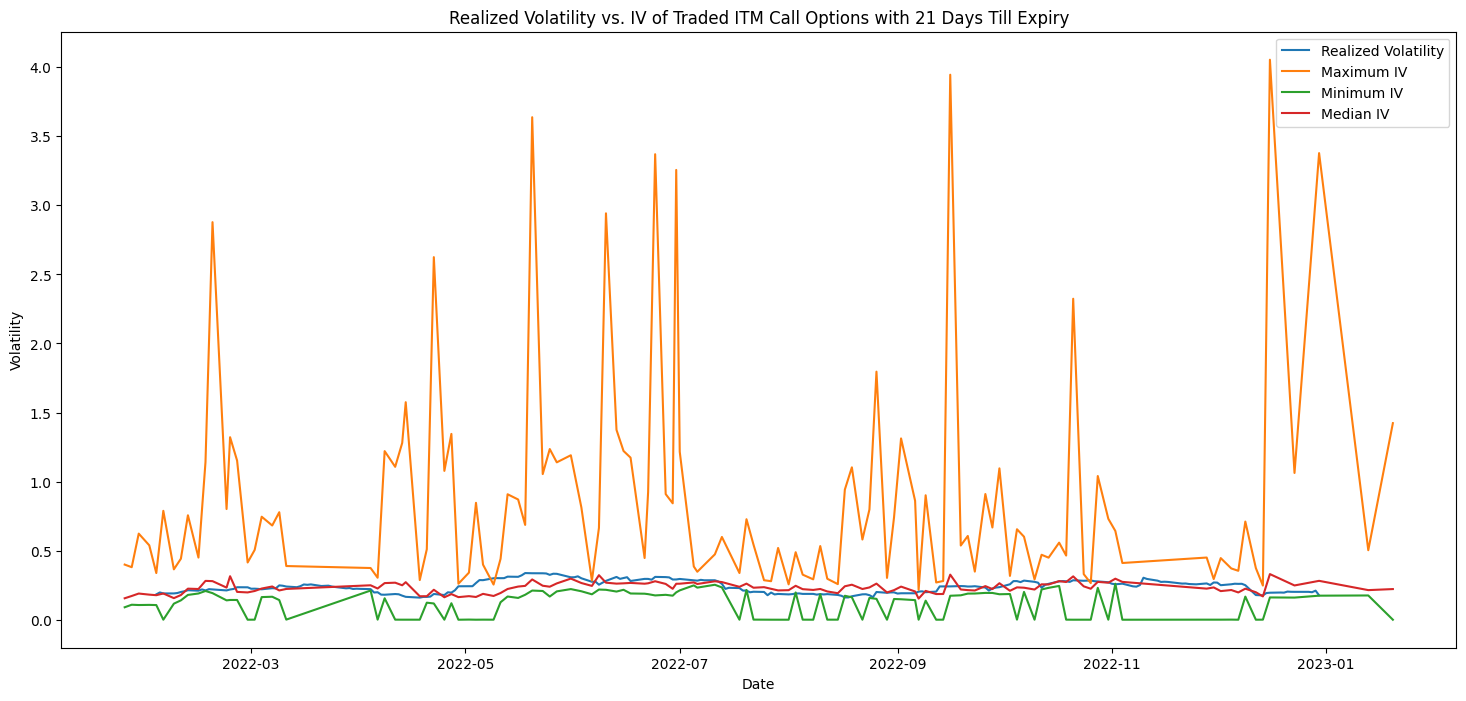

In [18]:
fig = plt.figure(figsize = (18,8))
plt.plot(spx_data["Realized Volatility"])
plt.plot(spx_iv_itm[("C IV", "<lambda_0>")])
plt.plot(spx_iv_itm[("C IV", "<lambda_1>")])
plt.plot(spx_iv_itm[("C IV", "<lambda_2>")])
plt.legend(["Realized Volatility", "Maximum IV", "Minimum IV", "Median IV"])
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Realized Volatility vs. IV of Traded ITM Call Options with 21 Days Till Expiry")
plt.show()

<Axes: ylabel='Density'>

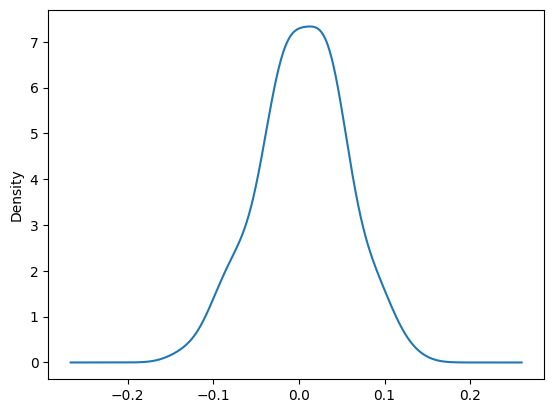

In [19]:
"""
Density Plot of Residuals for Median for ITM
"""
residuals = spx_data["Realized Volatility"] - spx_iv_itm[("C IV", "<lambda_2>")]
residuals.plot(kind="kde")

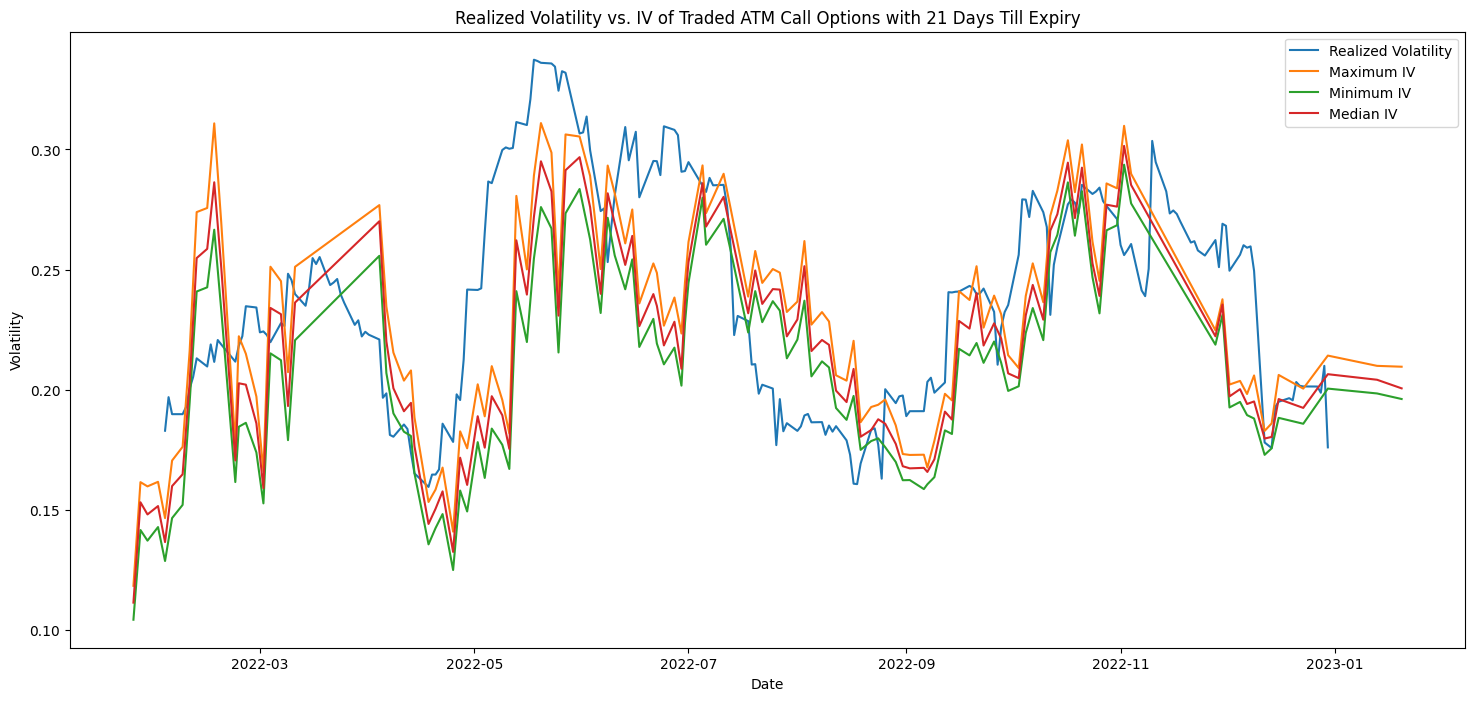

In [20]:
fig = plt.figure(figsize = (18,8))
plt.plot(spx_data["Realized Volatility"])
plt.plot(spx_iv_atm[("C IV", "<lambda_0>")])
plt.plot(spx_iv_atm[("C IV", "<lambda_1>")])
plt.plot(spx_iv_atm[("C IV", "<lambda_2>")])
plt.legend(["Realized Volatility", "Maximum IV", "Minimum IV", "Median IV"])
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Realized Volatility vs. IV of Traded ATM Call Options with 21 Days Till Expiry")
plt.show()

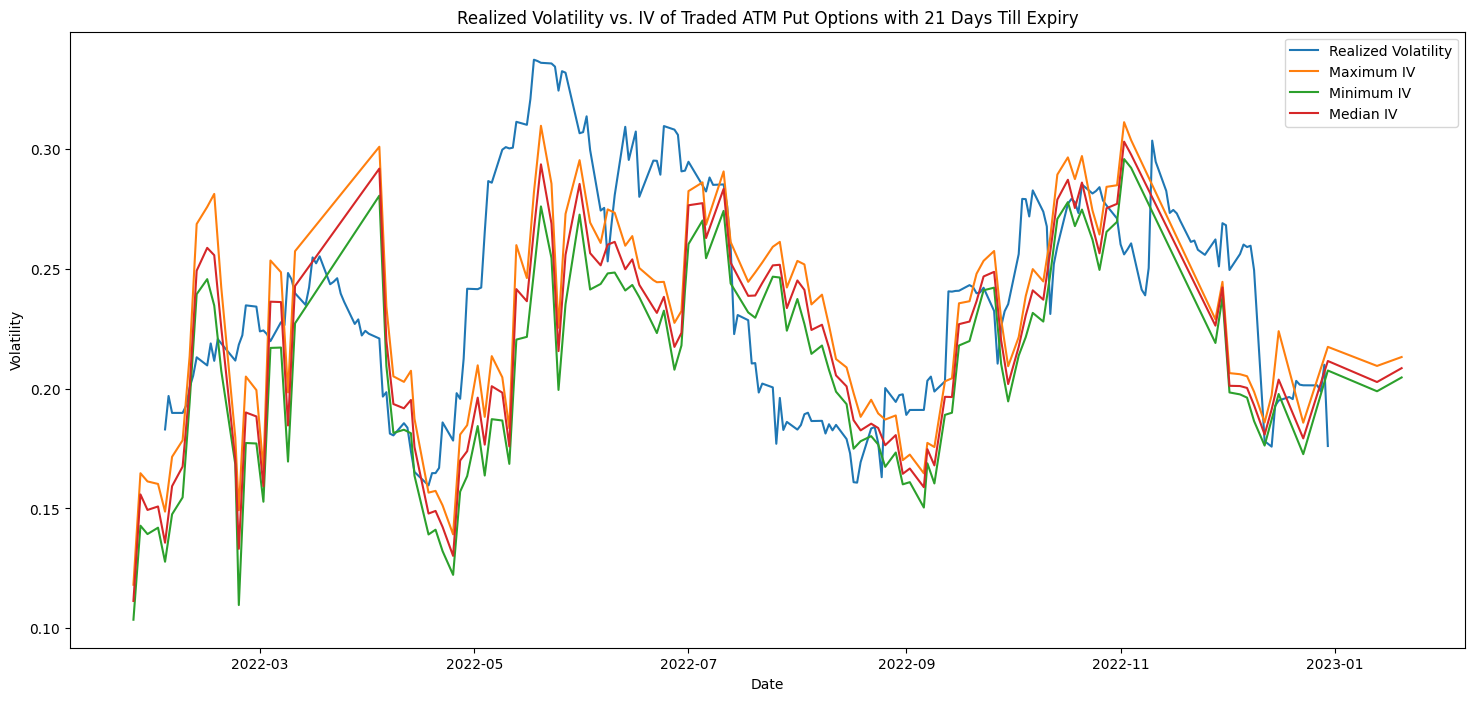

In [21]:
fig = plt.figure(figsize = (18,8))
plt.plot(spx_data["Realized Volatility"])
plt.plot(spx_iv_atm[("P IV", "<lambda_0>")])
plt.plot(spx_iv_atm[("P IV", "<lambda_1>")])
plt.plot(spx_iv_atm[("P IV", "<lambda_2>")])
plt.legend(["Realized Volatility", "Maximum IV", "Minimum IV", "Median IV"])
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Realized Volatility vs. IV of Traded ATM Put Options with 21 Days Till Expiry")
plt.show()

<Axes: ylabel='Density'>

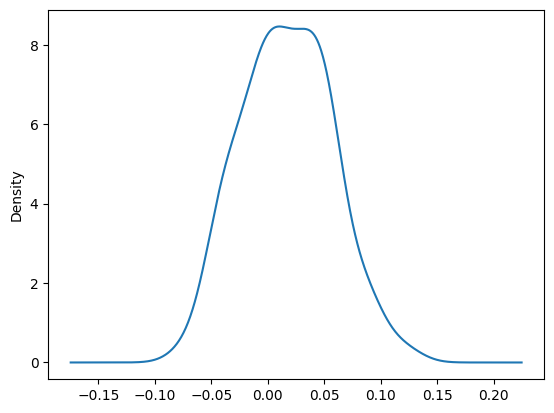

In [22]:
"""
Density Plot of Residuals for Median for ATM
"""
residuals = spx_data["Realized Volatility"] - spx_iv_atm[("C IV", "<lambda_2>")]
residuals.plot(kind="kde")

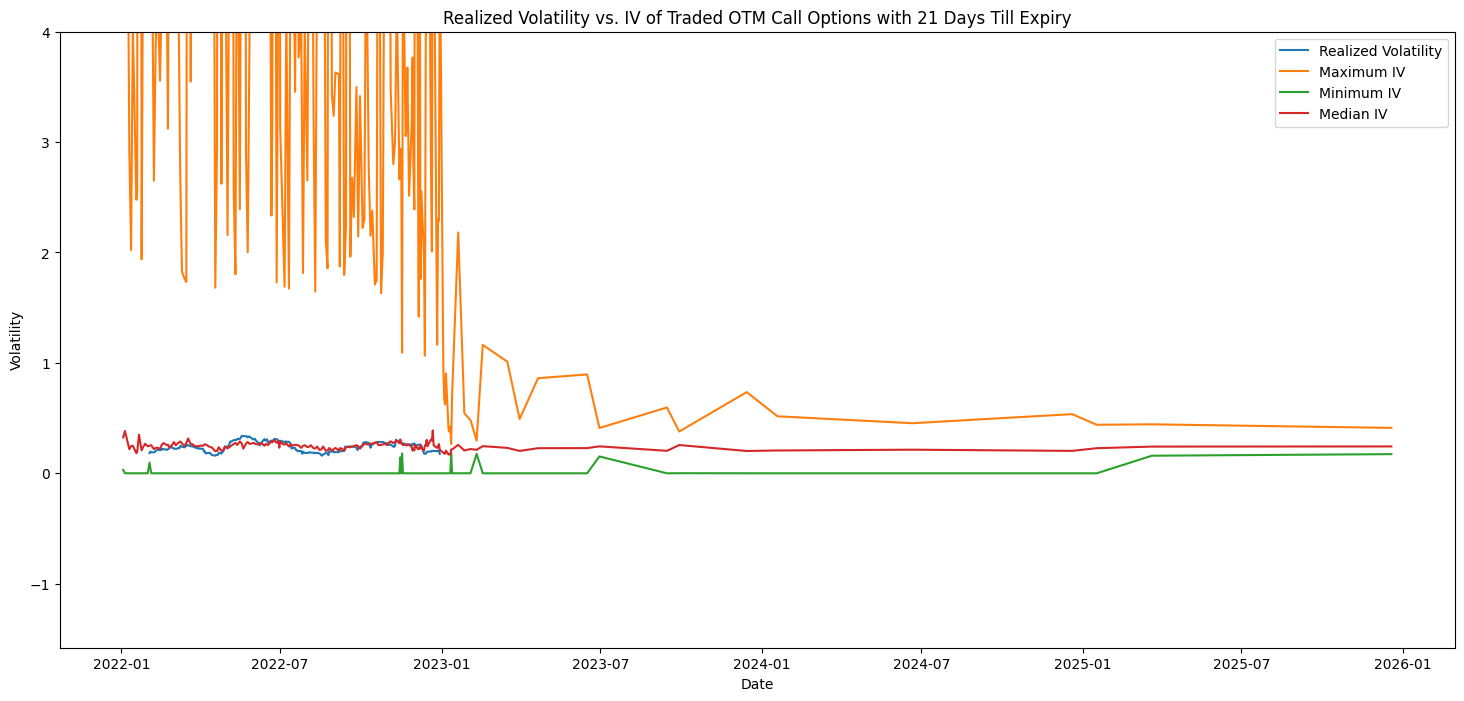

In [23]:
fig = plt.figure(figsize = (18,8))
plt.plot(spx_data["Realized Volatility"])
plt.plot(spx_iv_otm[("C IV", "<lambda_0>")])
plt.plot(spx_iv_otm[("C IV", "<lambda_1>")])
plt.plot(spx_iv_otm[("C IV", "<lambda_2>")])
plt.legend(["Realized Volatility", "Maximum IV", "Minimum IV", "Median IV"])
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.ylim(top=4)
plt.title("Realized Volatility vs. IV of Traded OTM Call Options with 21 Days Till Expiry")
plt.show()

<Axes: ylabel='Density'>

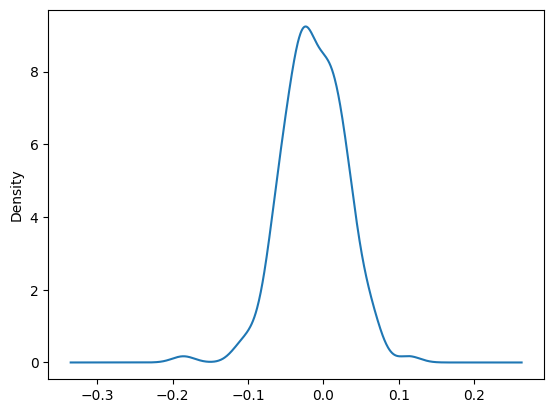

In [24]:
"""
Density Plot of Residuals for Median for OTM
"""
residuals = spx_data["Realized Volatility"] - spx_iv_otm[("C IV", "<lambda_2>")]
residuals.plot(kind="kde")

In [25]:
def plot_iv_realized_vol(dte, min_moneyness, max_moneyness):
    returns = distributions.get_returns("SPY", "2022-01-01", "2022-12-31")
    spy_data = pd.DataFrame({"Log Returns":returns})
    spy_data["Realized Volatility"] = get_realized_volatility(spy_data["Log Returns"], dte)
    
    options = pd.DataFrame()
    for quarter in range(1, 5):
        for part in range(1, 4):
            df = pd.read_csv(f"options_chain_data/spy_eod_2022/spy_eod_2022{'%02d' % (part + (3*(quarter-1)))}.txt")
            df = df.set_index(df.columns[1])
            df = df.rename(
                columns = lambda x: x.replace(" ", "").replace("[", "").replace("]", "").replace("_"," ")
                )
            df = df.drop(columns = df.columns[[0,5]])
            options = pd.concat((options,df))

    options = options.replace(" ", np.nan)
    for col in ["C IV", "P IV", "C DELTA"]:
        options[col] = pd.to_numeric(options[col])

    spy_iv = options[(options["DTE"] == dte) & (options["C DELTA"] >= min_moneyness) & (options["C DELTA"] <= max_moneyness)]\
        .groupby("EXPIRE DATE").agg(
        {"C IV":[lambda x: max(x.dropna()), lambda x: min(x.dropna()), lambda x: median(x.dropna())], 
        "P IV": [lambda x: max(x.dropna()), lambda x: min(x.dropna()), lambda x: median(x.dropna())]}
        )
    spy_iv.index = pd.to_datetime(spy_iv.index)
    fig = plt.figure(figsize = (18,8))
    plt.plot(spy_data["Realized Volatility"])
    plt.plot(spy_iv[("C IV", "<lambda_0>")])
    plt.plot(spy_iv[("C IV", "<lambda_1>")])
    plt.plot(spy_iv[("C IV", "<lambda_2>")])
    plt.legend(["Realized Volatility", "Maximum IV", "Minimum IV", "Median IV"])
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.title(f"Realized Volatility vs. IV of Traded Call Options with {dte} Days Till Expiry")
    plt.show()

    residuals = spy_data["Realized Volatility"] - spy_iv[("C IV", "<lambda_1>")]
    residuals.plot(kind="kde")

[*********************100%%**********************]  1 of 1 completed
C:\Users\Tayo\AppData\Local\Temp\ipykernel_30396\384324968.py:9: DtypeWarning: Columns (15,17,18,20,21,23,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"options_chain_data/spy_eod_2022/spy_eod_2022{'%02d' % (part + (3*(quarter-1)))}.txt")
C:\Users\Tayo\AppData\Local\Temp\ipykernel_30396\384324968.py:9: DtypeWarning: Columns (15,17,18,20,21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"options_chain_data/spy_eod_2022/spy_eod_2022{'%02d' % (part + (3*(quarter-1)))}.txt")
C:\Users\Tayo\AppData\Local\Temp\ipykernel_30396\384324968.py:9: DtypeWarning: Columns (15,17,18,20,21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"options_chain_data/spy_eod_2022/spy_eod_2022{'%02d' % (part + (3*(quarter-1)))}.txt")
C:\Users\Tayo\AppData\Local\Temp\ipykernel_30396\384324968.py:9:

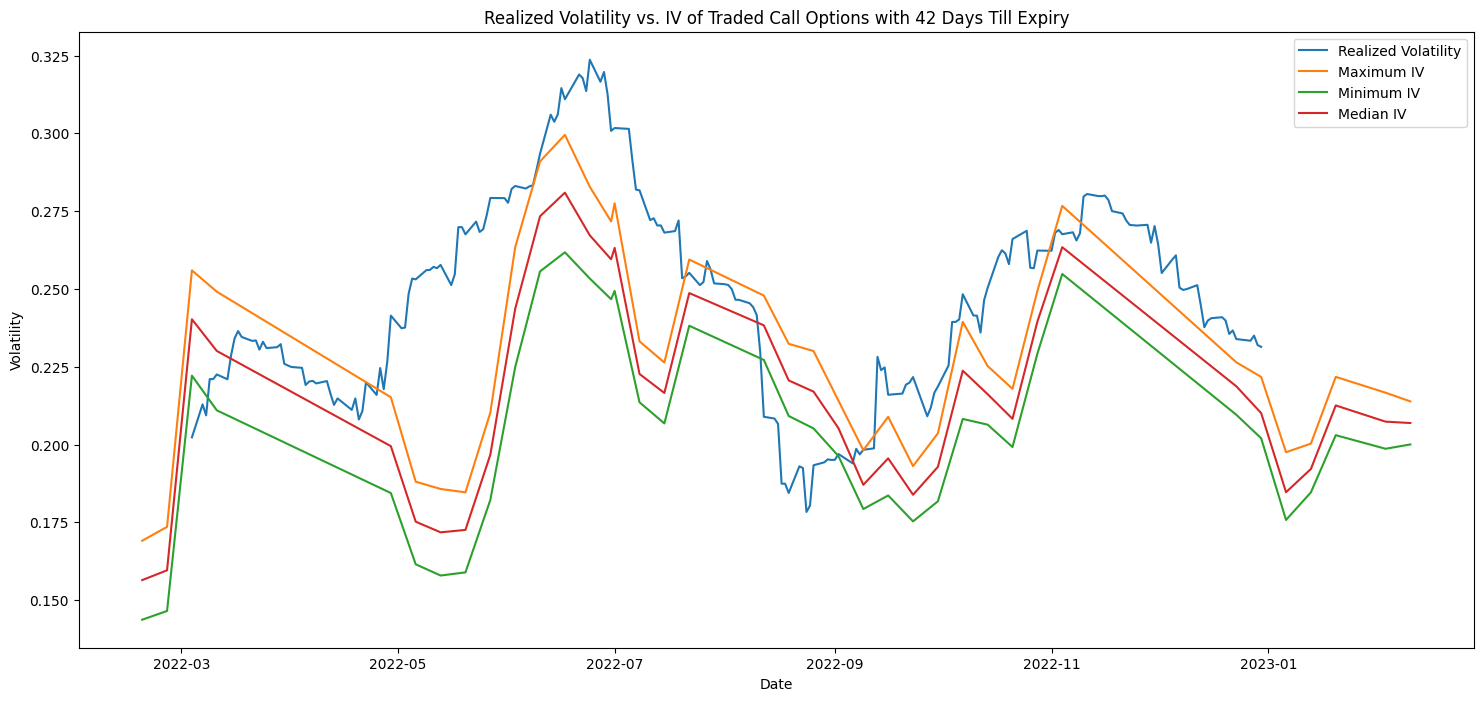

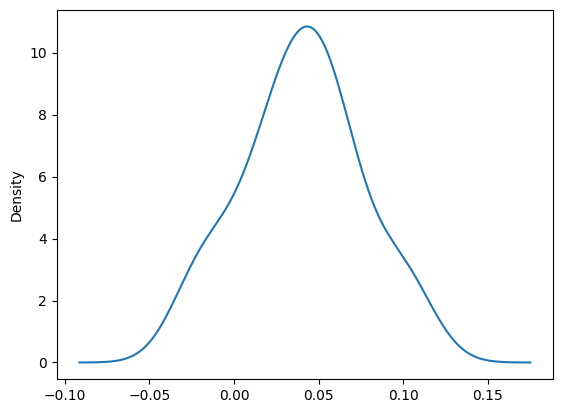

In [26]:
plot_iv_realized_vol(42, 0.4, 0.6)

### 3. Comparing Residuals Between Options Chain and Realized Underlying